# Invert Geopotential model using SOR method
**10 May 2021 by MiniUFO**

---

[TOC]

---

## 1. Introduction
Geopotential model ([Yuan et al. 2008](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.337)), also known as the divergence equation, represents a relation between the mass (geopotential $\Phi$ in atmospheric context, or sea surface height $\eta$ in oceanic context) and horizontal flow $(u,v)$ fields.  Given the mass field, one can invert the flow field and vice versa.  The simplest case is to derive the geostrophic flow given the mass field.  Similarly, given the flow field, one can obtain the balanced mass field.  This is particularly useful in data assimilation, such as the the technique of normal mode initialization.  In this initialization, given a mass (flow) observation, one need to calculate the balanced flow (mass) field so that the high-frequency oscillations are removed.  This prevents the model integration from overflow by initial shocks such as fast gravity waves.

In Cartesian coordinates, assuming barotropic flow, applying the horizontal divergence operator $\nabla_h\cdot()$ to the vector form of the horizontal momentum equation of $\vec{v_h}$, one obtains the divergence $D=\nabla_h\cdot\vec{v_h}$ equation as:
$$\frac{\partial D}{\partial t}=-\vec{v_h}\cdot\nabla D - D^2 - \nabla^2 \Phi + f\zeta-u\beta+\nabla\cdot\vec{F}\tag{1}$$

The first two terms on the rhs of Eq. (1) is the nonlinear terms, the third to fifth terms are the geostrophic balance terms, and the last term is the divergence of frictional stress.  Here we are going to consider a case on the spherical coordinates, possibly include the vertical advection if flow is not barotropic, and keep as many terms as possible for the inversion.


## 2. Theory
Here the derivation of the geopotential model (or equivalently, the divergence equation) is briefly reviewed.  The start point is the horizontal momentum $(u,v)$ equations in spherical-pressure coordinates:
$$\begin{align}\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}+\omega\frac{\partial u}{\partial p}=-\frac{\partial \Phi}{\partial x}+fv+\frac{uv\tan\phi}{a}+F_{\lambda}\tag{2}\\ \frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}+\omega\frac{\partial v}{\partial p}=-\frac{\partial \Phi}{\partial y}-fu-\frac{u^2\tan\phi}{a}+F_{\phi} \tag{3}\end{align}$$

where $\partial x=a\cos\phi\partial \lambda$ and $\partial y=a\partial\phi$ are the short-hands.  Taking $\partial/\partial x$ and $\partial \cos\phi() /\partial y/\cos\phi$ respectively of Eqs. (2) and (3), and suming up the results gives the divergence ($D$) equation:
$$\begin{align}\frac{\partial D}{\partial t}=&-\vec{u}\cdot\nabla D-D^2-\frac{\partial}{\partial x}\left(\omega\frac{\partial u}{\partial p}\right)-\frac{1}{\cos \phi}\frac{\partial}{\partial y}\left(\omega\cos\phi\frac{\partial v}{\partial y}\right)\notag\\&-\nabla^2\Phi+f\zeta-u\beta\notag\\&+\frac{\partial }{\partial x}\left(\frac{uv\tan\phi}{a}\right)-\frac{\partial}{\partial y}\left(\frac{u^2\sin\phi}{a}\right)+\nabla \cdot\vec{F}\tag{4}\end{align}$$

### 2.1 Geopotential model
If the geopotential $\Phi$ is taken as the unknown and the 3D flow $(u,v,\omega)$ as the knowns, then Eq. (4) is a Poisson equation with respect to $\Phi$ as:
$$\begin{align}\nabla^2\Phi=&-\frac{\partial D}{\partial t}-\vec{u}\cdot\nabla D-D^2-\frac{\partial}{\partial x}\left(\omega\frac{\partial u}{\partial p}\right)-\frac{1}{\cos \phi}\frac{\partial}{\partial y}\left(\omega\cos\phi\frac{\partial v}{\partial y}\right)\notag\\&+f\zeta-u\beta\notag\\&+\frac{\partial }{\partial x}\left(\frac{uv\tan\phi}{a}\right)-\frac{1}{\cos \phi}\frac{\partial}{\partial y}\left(\frac{u^2\sin\phi}{a}\right)+\nabla \cdot\vec{F}\tag{5}\end{align}$$

One needs to calculate the forcing terms on the rhs of Eq. (4) using 3D flow $(u,v,\omega)$ data and then invert for geopotential $\Phi$.

### 2.2 Geostrophic streamfunction model
If the flow fields are unknown and the mass field can be observed (e.g., in oceanic context, the sea surface height can be directly observed by altimetry satellites), Eq. (5) has to be simplied somehow for inversion.  First, one need to remove nonlinear terms and the frictional term, which is also known as linearization.  Then introducing the streamfunction $\psi$ so that the horizontal flow is nondivergent.  This results in the geostrophic balance as:
$$\nabla \cdot(f\nabla\psi)=\nabla^2\Phi\tag{6}$$

Similarly, given the mass field, one can invert the geostrophic streamfunction iteratively.  However, near the equator, $f\rightarrow0$ and Eq. (6) is not elliptic at the equator.  


## 3. Examples
### 3.1 The geopotential model example
Now we have a global horizontal wind field $(u,v)$, and we want to recover the geopotential field $\Phi$.  All the terms on the rhs of Eq. (5) will be calculated and then inverted using SOR accordingly for each responses.  The code is as follows.

In [1]:
### geopotential model example ###
import sys
sys.path.append('../../')
import xarray as xr

# loading data from a dataset
ds = xr.open_dataset('../Data/atmos3D.nc').sel({'LEV':500})

u = ds.U
v = ds.V
h = ds.hgt

Calculate each forcing on the rhs of Eq. (5).

In [2]:
### calculate each forcing ###
import numpy as np
import xarray as xr
from GeoApps.DiagnosticMethods import Dynamics
from GeoApps.GridUtils import add_latlon_metrics
from GeoApps.ConstUtils import omega, Rearth


dset, grid = add_latlon_metrics(ds)

dyn = Dynamics(dset, grid, arakawa='A')

vort = dyn.curl(u, v)
cosF = np.cos(np.deg2rad(u.lat))
sinF = np.sin(np.deg2rad(u.lat))
beta = 2.0 * omega * cosF / Rearth
fcor = 2.0 * omega * sinF


# force 2
tmp2 = grid.derivative(u, 'X') * grid.interp(u, 'X')
frc2 = -grid.derivative(tmp2, 'X').load()
frc2 = xr.where(np.isfinite(frc2), frc2, np.nan)

# force 3
tmp3 = grid.interp(grid.derivative(v, 'X'), 'X') * u * cosF
frc3 = -grid.interp(grid.derivative(tmp3, 'Y', boundary='extend'), 'Y', boundary='extend').load() / cosF
frc3 = xr.where(np.isfinite(frc3), frc3, np.nan)

# force 4
tmp4 = grid.interp(grid.derivative(u, 'Y', boundary='extend'), 'Y', boundary='extend') * v
frc4 = -grid.interp(grid.derivative(tmp4, 'X'), 'X').load()
frc4 = xr.where(np.isfinite(frc4), frc4, np.nan)

# force 5
tmp5 = grid.derivative(v, 'Y', boundary='extend') * grid.interp(v*cosF, 'Y', boundary='extend')
frc5 = -grid.derivative(tmp5, 'Y', boundary='extend').load() / cosF
frc5 = xr.where(np.isfinite(frc5), frc5, np.nan)

# force 9
frc9 = (fcor * vort).load()
frc9 = xr.where(np.isfinite(frc9), frc9, np.nan)

# force 10
frc10 = -(u * beta).load()
frc10 = xr.where(np.isfinite(frc10), frc10, np.nan)

# force 11
tmp11 = -u**2 * sinF / Rearth
frc11 = grid.interp(grid.derivative(tmp11, 'Y', boundary='extend'), 'Y', boundary='extend').load() / cosF
frc11 = xr.where(np.isfinite(frc11), frc11, np.nan)

# force 12
tmp12 = u * v * sinF / cosF / Rearth
frc12 = grid.interp(grid.derivative(tmp12, 'X'), 'X').load()
frc12 = xr.where(np.isfinite(frc12), frc12, np.nan)


# all forces
frcAll = frc2 + frc3 + frc4 + frc5 + frc9 + frc10 + frc11 + frc12
frcAll = xr.where(np.isfinite(frcAll), frcAll, np.nan) # change inf to nan

curl() is deprecated.  Using vort(u=u, v=v, components='k') instead


C:\ProgramData\Anaconda3\lib\site-packages\xgcm\grid.py:2313: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
C:\ProgramData\Anaconda3\lib\site-packages\xgcm\grid.py:2313: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
C:\ProgramData\Anaconda3\lib\site-packages\xgcm\grid.py:2309: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
C:\ProgramData\Anaconda3\lib\site-packages\xgcm\grid.py:2309: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
C:\ProgramData\Anaconda3\lib\site-packages\xgcm\grid.py:2309: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


Inverting geopotential response to each forcing.

In [3]:
### inverting ###
from xinvert.xinvert import invert_Poisson

hbc = (h*9.81).load() # boundary values

iParams = {
    'BCs'      : ['fixed', 'periodic'],
    'mxLoop'   : 5000,
    'tolerance': 1e-12,
}

sf = invert_Poisson(frcAll, dims=['lat','lon'], icbc=hbc, iParams=iParams)

{} loops 1670 and tolerance is 0.000000e+00


Now we can plot the forcings and responses.

C:\ProgramData\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


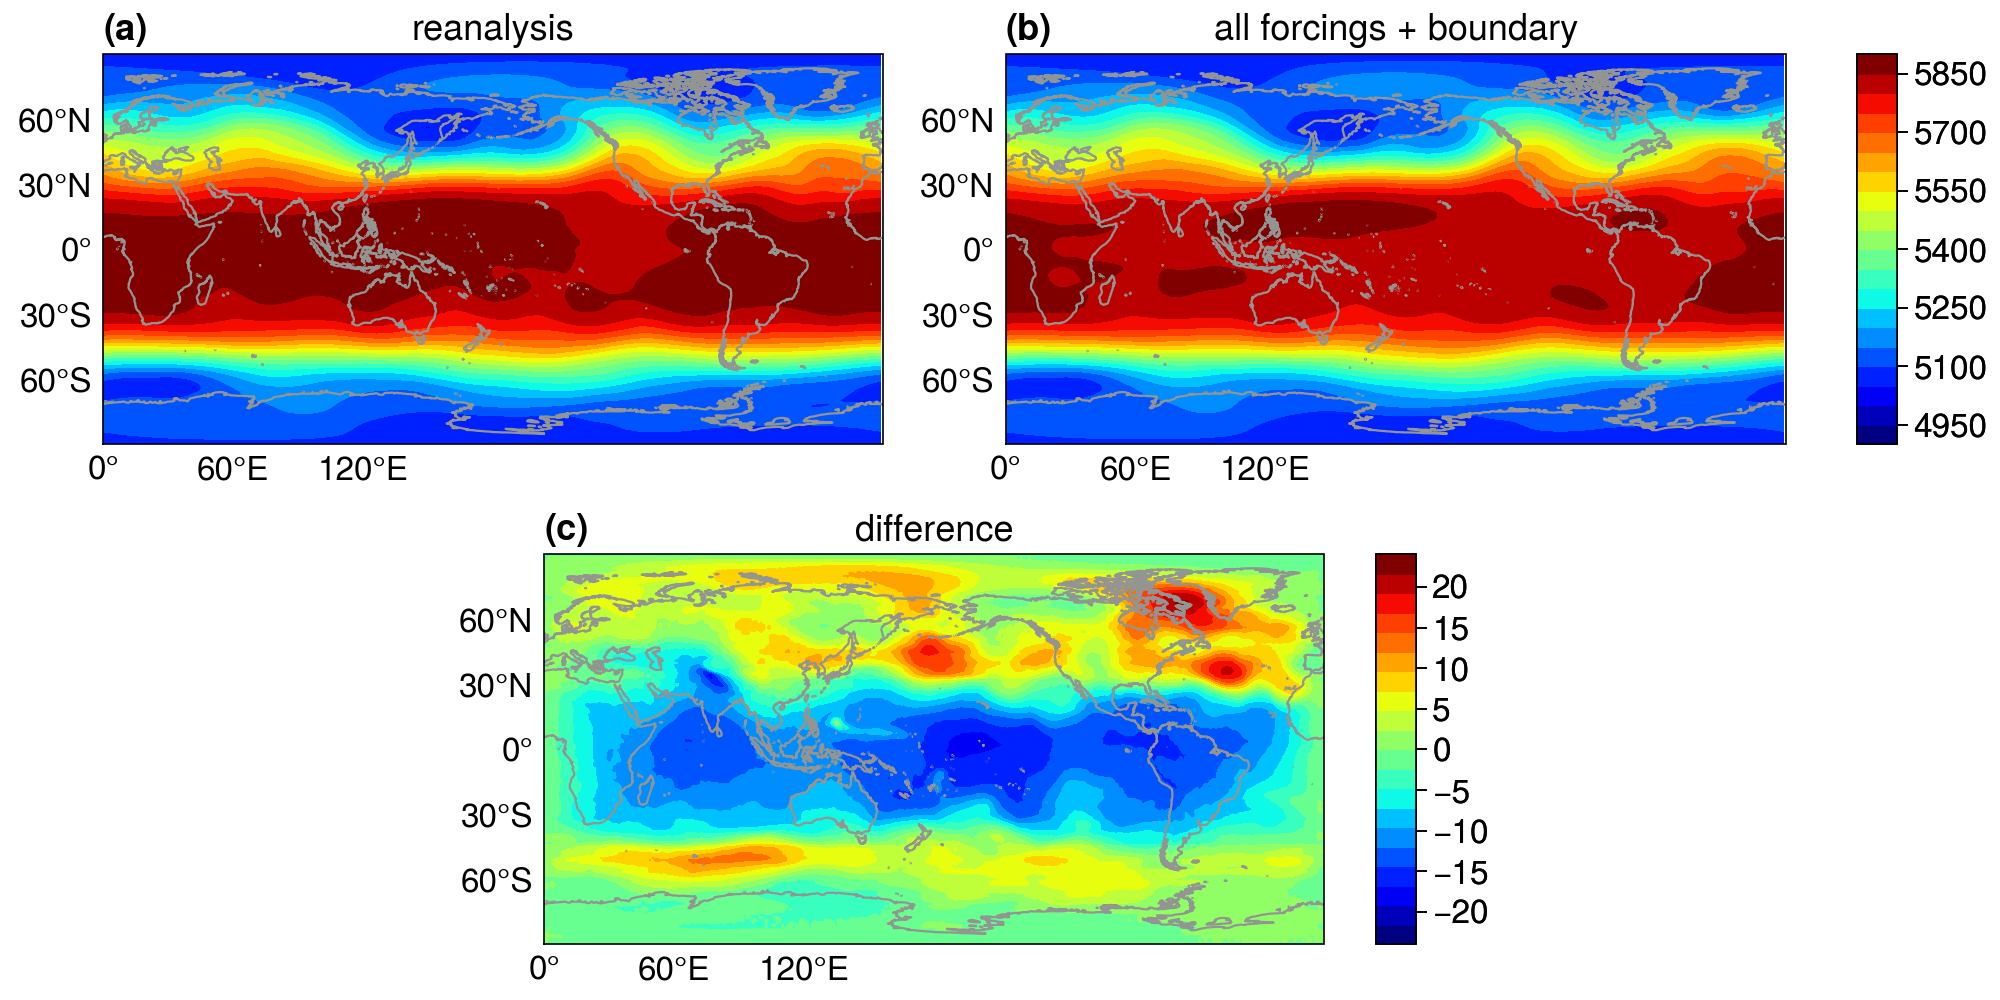

In [4]:
### plot the sum-ups, observed, and difference ###
import proplot as pplt

array = [
    [1, 1, 2, 2],
    [0, 3, 3, 0],
]

fig, axes = pplt.subplots(array, figsize=(10, 5), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))

fontsize = 13

ax = axes[0]
p=ax.contourf(h, cmap='jet', levels=np.linspace(4900, 5900,21))
ax.set_title('reanalysis', fontsize=fontsize)
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])

ax = axes[1]
p=ax.contourf(sf/9.81, cmap='jet', levels=np.linspace(4900, 5900,21))
ax.set_title('all forcings + boundary', fontsize=fontsize)
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', length=1, label='', ticks=150)

ax = axes[2]
p=ax.contourf(sf/9.81-h, cmap='jet', levels=np.linspace(-24, 24,21))
ax.set_title('difference', fontsize=fontsize)
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', length=1, label='', ticks=5)

axes.format(abc='(a)', coast=True,
            lonlines=60, latlines=30, lonlabels='b', latlabels='l',
            grid=False, labels=False)

From Fig. (a) and (b) one can see clearly that the inverted and reanalysis are almost the same.  Differences may be caused by neglecting the terms related to vertical motion and temporal change of divergence.

### 3.2 The geostrophic flow example
In contrast to the above example, if we know the mass field $\Phi$, we can calculate the geostrophic flow field accordingly.  In order to prevent the $f=0$ at the equator, we shift the grid slightly so that it locates on both sides of the equator.

In [5]:
from xinvert.xinvert import FiniteDiff

# load data
Phi = (h*9.81).load()

fd = FiniteDiff(dim_mapping={'Z':'LEV', 'Y':'lat', 'X':'lon'},
                BCs={'Z':['extend', 'extend'],
                     'Y':['extend', 'extend'],
                     'X':['periodic','periodic']},
                coords='lat-lon', fill=0)

# calculate rhs forcing of Eq. (6)
force = fd.Laplacian(Phi, dims=['Y', 'X'])

latNew = (h.lat + h.lat.diff('lat')[0]/2.0)[:-1]

ny, nx = force.shape

forceHalf = force.interp_like(xr.DataArray(np.zeros((ny-1, nx)), dims=['lat','lon'], coords={'lat':latNew, 'lon':h.lon})).load()

Inverting for geostrophic streamfunction $\Phi$:

In [7]:
#%% invert
from xinvert.xinvert import invert_geostrophic

iParams = {
    'BCs'      : ['fixed', 'periodic'],
    'mxLoop'   : 5000,
    'tolerance': 1e-12,
}

sf = invert_geostrophic(forceHalf, dims=['lat','lon'], iParams=iParams)

{} loops 5000 and tolerance is 8.480862e-10


Results can be plotted as:

C:\ProgramData\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


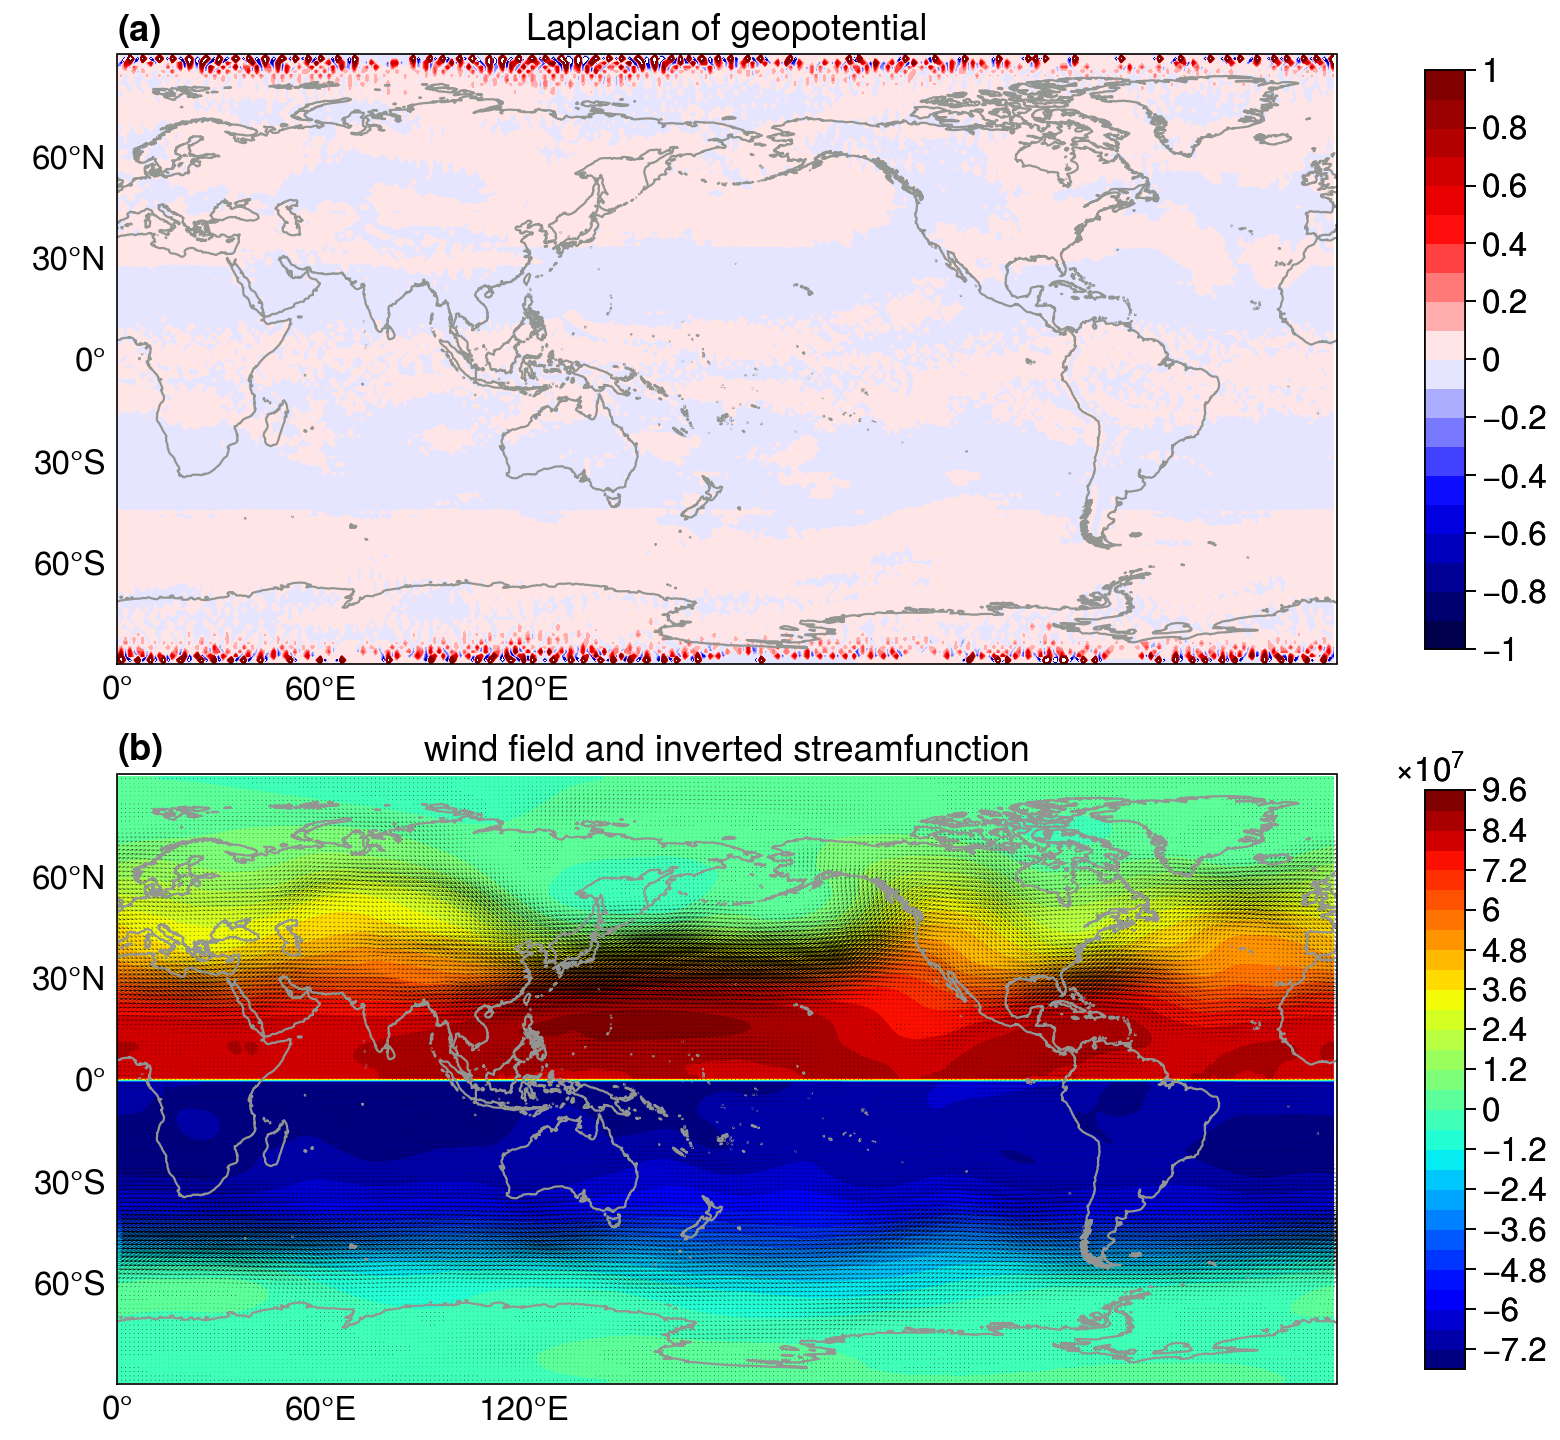

In [8]:
#%% plot wind and streamfunction
import proplot as pplt

m = np.hypot(u, v)

lat, lon = xr.broadcast(u.lat, u.lon)
fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(7.8, 7.2), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))
fontsize = 13

axes.format(abc='(a)', coast=True,
            lonlines=60, latlines=30, lonlabels='b', latlabels='l',
            grid=False, labels=False)

ax = axes[0]
p = ax.contourf(force*1e7, cmap='seismic',
                levels=np.linspace(-1, 1, 21))
ax.set_title('Laplacian of geopotential', fontsize=fontsize)
ax.colorbar(p, loc='r', label='', ticks=0.2, length=0.95)

ax = axes[1]
p = ax.contourf(sf, levels=31, cmap='jet')
ax.quiver(lon.values, lat.values, u.values, v.values,
              width=0.0007, headwidth=12., headlength=15.)
              # headwidth=1, headlength=3, width=0.002)
ax.set_title('wind field and inverted streamfunction', fontsize=fontsize)
ax.colorbar(p, loc='r', label='', length=0.95)

Note that there is a jump of the streamfunction $\Phi$ at the equator.  If we add a constant to the Southern Hemisphere to remove the jump, then the streamfunction field will look much better:

C:\ProgramData\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


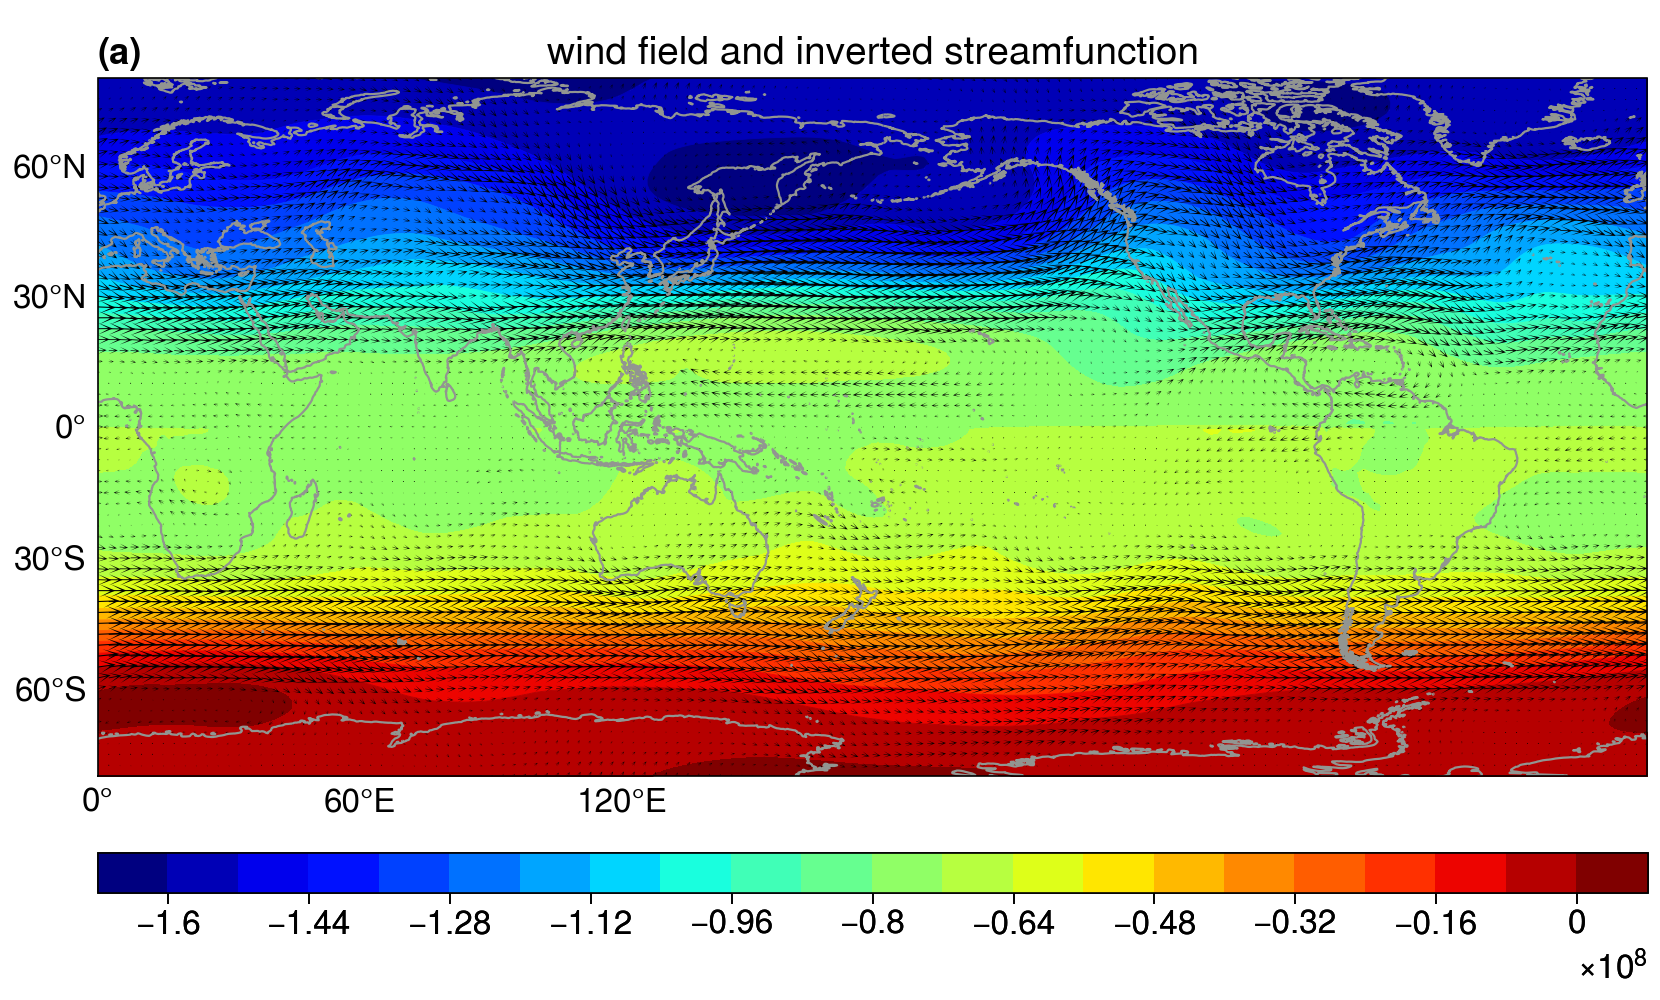

In [13]:
#%% plot wind and streamfunction
import proplot as pplt

sfm = sf.mean('lon')
sf2 = sf.copy()

sf2.loc[:0] += ((sfm[72]-sfm[71])/2.0 - sfm[71]).values

fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(8.3, 5), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))
fontsize = 14

axes.format(abc='(a)', coast=True,
            lonlines=60, latlines=30, lonlabels='b', latlabels='l',
            grid=False, labels=False)

ax = axes[0]
p = ax.contourf(sf2, levels=21, cmap='jet')
ax.set_ylim([-80, 80])
ax.set_xlim([-180, 175])
ax.quiver(lon.values[::2,::2], lat.values[::2,::2], u.values[::2,::2], v.values[::2,::2],
              width=0.0007, headwidth=12., headlength=15.)
              # headwidth=1, headlength=3, width=0.002)
ax.set_title('wind field and inverted streamfunction', fontsize=fontsize)
ax.colorbar(p, loc='b', label='', length=1)

This is the observed wind field and is aligned with the streamfunction, especially away from the tropics.  Even in the equatorial regions, the wind is along the streamfunction.

---

### References
1. Yuan Z., J. Wu, X. Cheng, and M. Jian 2008: [The derivation of a numerical diagnostic model for the forcing of the geopotential.](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.337) *Q. J. R. Meteorol. Soc.*, **134**, 2067-2078.